## Graph Convolutional Networks (GCN): Classificação de vértices/nós em um grafo
 
![sd](https://pytorch-geometric.readthedocs.io/en/latest/_images/neighbor_loader.png "Title")

## Instalando dependências

In [1]:
!pip install torch_geometric
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.3.0+cpu.html
!pip install matplotlib networkx[default,extra]
!pip install tabulate

Looking in links: https://data.pyg.org/whl/torch-2.3.0+cpu.html


## Explorando o dataset 'Cora'
- Grafo de citações
- Vértices/Nós representam documentos
- Arestas representam citações entre documentos
- Cada vértice possui um conjunto de características (features): bag of words, indicando a ocorrência ou não de certas palavras de um dicionário nos documentos
- Cada vértice também possui uma classe de documento (7 classes)
- Referência: https://arxiv.org/pdf/1603.08861

In [2]:
from torch_geometric.datasets import Planetoid

# conjunto de dados já incluído no pyg, composto de um único grafo
#dataset = Planetoid(".", name='Cora', split="", force_reload=True)
dataset = Planetoid(".", name='Cora', split="public")
data = dataset[0]
print(f"\nGrafo Cora:\n{data}")
print(f"\nArestas:\n{data.edge_index}")
print(f"\nFeatures dos vértices (bag of words):\n{data.x}")
print(f"\nClasses dos vértices (categorias de documentos):\n{data.y}\n{data.y.unique()}")


Grafo Cora:
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

Arestas:
tensor([[ 633, 1862, 2582,  ...,  598, 1473, 2706],
        [   0,    0,    0,  ..., 2707, 2707, 2707]])

Features dos vértices (bag of words):
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

Classes dos vértices (categorias de documentos):
tensor([3, 4, 4,  ..., 3, 3, 3])
tensor([0, 1, 2, 3, 4, 5, 6])


### Entendendo as máscaras de treino, validação e teste
Observe que como ```split="public"```, as máscaras já estão fixadas da maneira que o dado foi utilizado no artigo publicado (reproducibilidade).

In [3]:
print(f"\nMáscara de treino:\n{data.train_mask}")
print(f"\nMáscara de validação:\n{data.val_mask}")
print(f"\nMáscara de teste:\n{data.test_mask}")


Máscara de treino:
tensor([ True,  True,  True,  ..., False, False, False])

Máscara de validação:
tensor([False, False, False,  ..., False, False, False])

Máscara de teste:
tensor([False, False, False,  ...,  True,  True,  True])


### Visualizando uma amostra do grafo

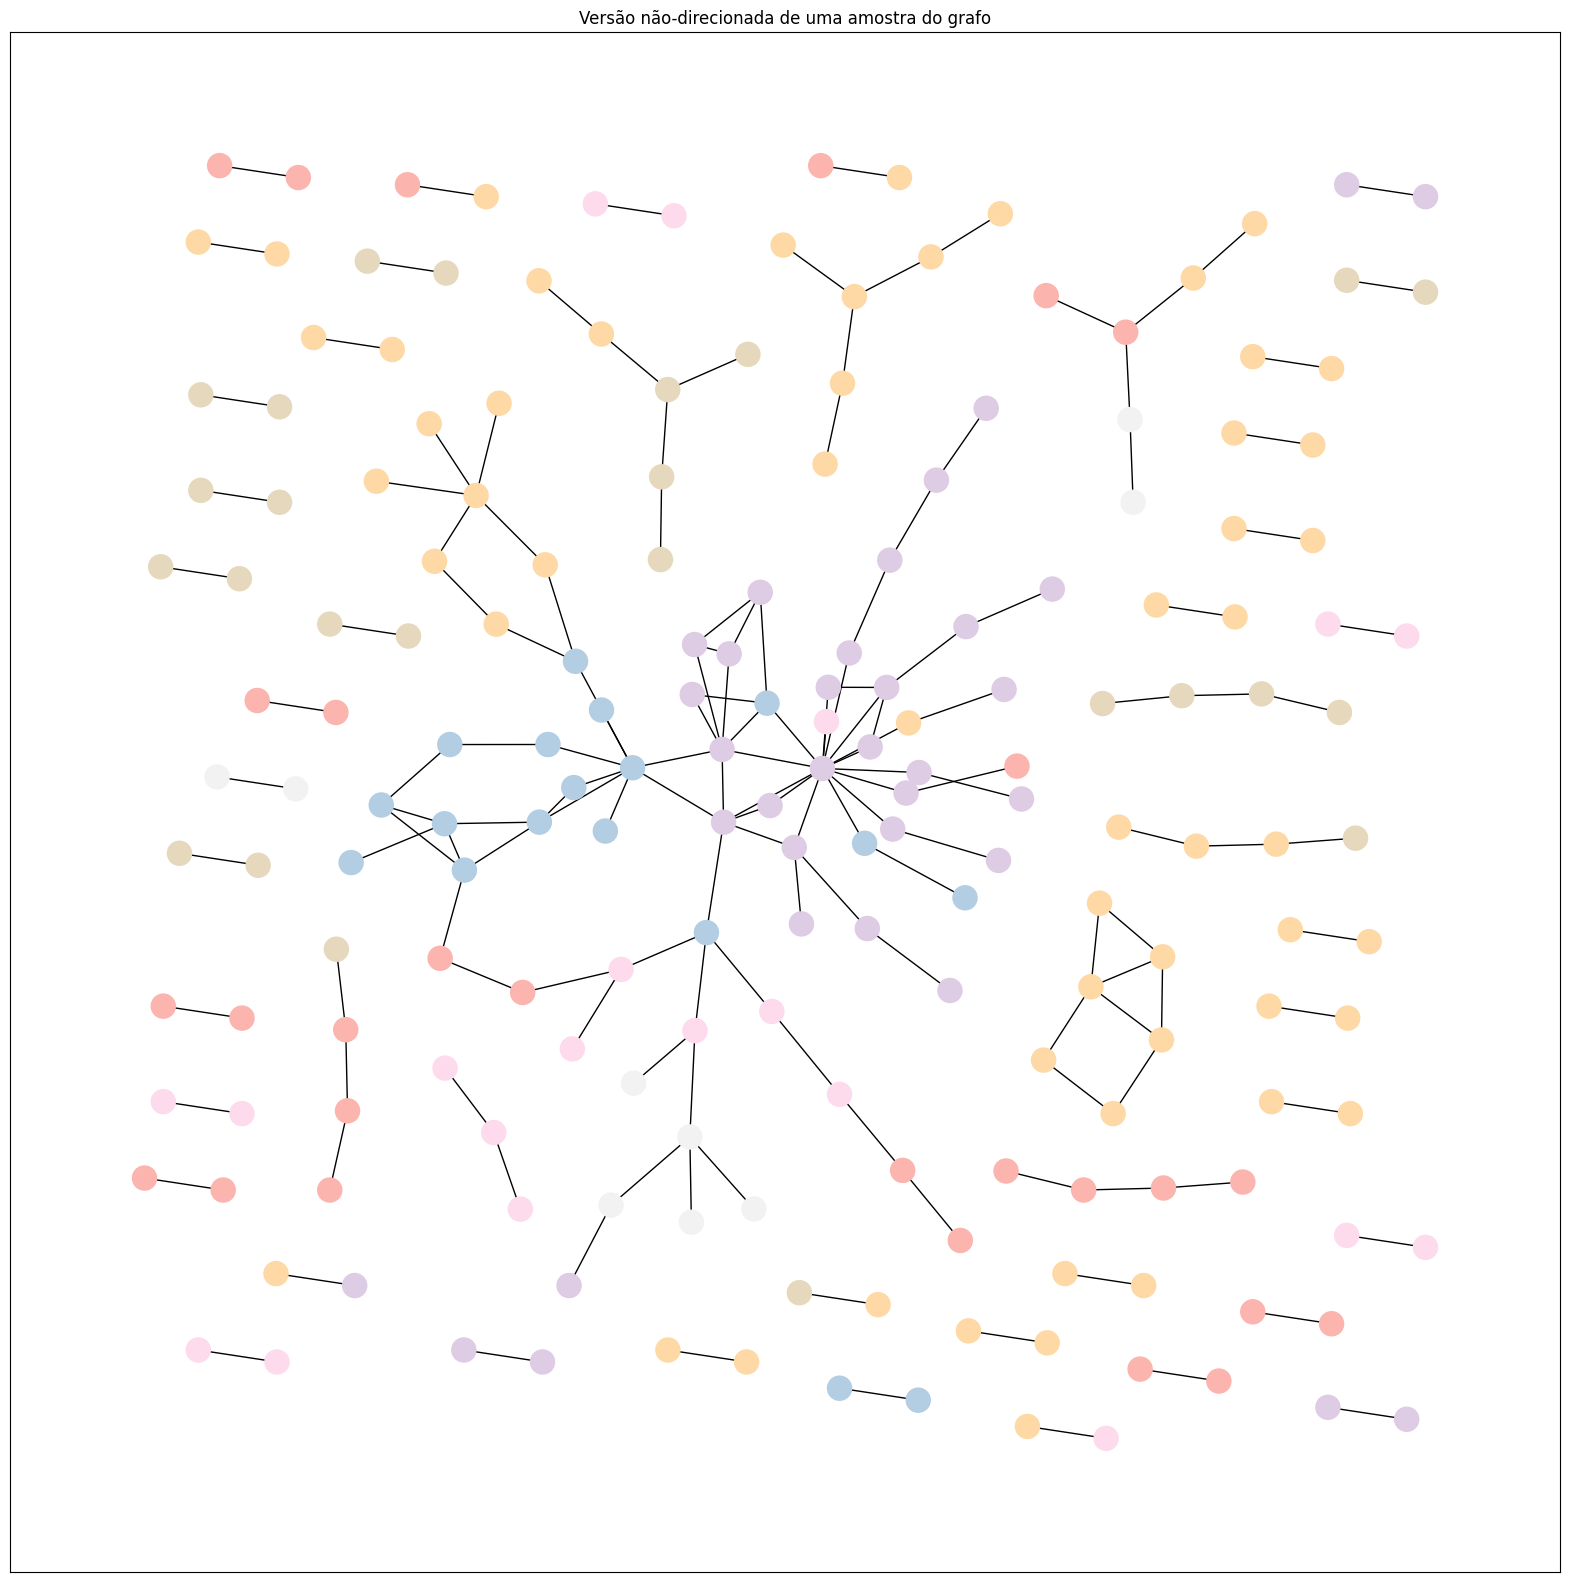

In [4]:
import networkx as nx
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt
import random

# sample a subgraph with 100 edges (random)
k = 100
g = to_networkx(data, node_attrs=["y"], to_undirected=True)
sampled_edges = random.sample(sorted(g.edges), k)
sampled_nodes = list(set(list(sum(sampled_edges, ()))))
sampled_graph = g.subgraph(sampled_nodes)

# draw graph with colors representing document classes
plt.figure(figsize=(20, 20))
plt.title("Versão não-direcionada de uma amostra do grafo")
labels = nx.get_node_attributes(sampled_graph, "y", default=-1)
pos = nx.nx_agraph.graphviz_layout(sampled_graph, prog="neato")
nx.draw_networkx_nodes(sampled_graph, pos, node_color=list(labels.values()), cmap=plt.cm.Pastel1)
nx.draw_networkx_edges(sampled_graph, pos)

plt.show()

## Modelo Graph Convolutional Networks: classificador multi-label como tarefa final

### Definindo uma rede neural convolucional em grafos
- Conceito de convolução em grafos

In [13]:
import time

import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.first_epoch = True

    def forward(self, x, edge_index, edge_weight=None):
        if self.first_epoch: print(f"\nFeatures {x.shape}\n{x}\n")
        
        x = F.dropout(x, p=0.5, training=self.training)
        if self.first_epoch: print(f"\nDropout {x.shape}\n{x}\n")
        
        x = self.conv1(x, edge_index, edge_weight)
        if self.first_epoch: print(f"\nConv1 {x.shape}\n{x}\n")
        
        x = F.relu(x)
        if self.first_epoch: print(f"\nReLU {x.shape}\n{x}\n")
        
        x = F.dropout(x, p=0.5, training=self.training)
        if self.first_epoch: print(f"\nDropout {x.shape}\n{x}\n")
        
        x = self.conv2(x, edge_index, edge_weight)
        if self.first_epoch: print(f"\nConv2 {x.shape}\n{x}\n")
        
        x = F.softmax(x, dim=1)
        if self.first_epoch: print(f"\nSoftmax {x.shape}\n{x}\n")
        
        self.first_epoch = False
        return x


# define o modelo
device = 'cuda' if torch.cuda.is_available() else 'cpu'
hidden_channels = 16 # indica quantos parâmetros (pesos) serão utilizados na primeira convolução
model = GCN(
    in_channels=dataset.num_features,
    hidden_channels=hidden_channels,
    out_channels=dataset.num_classes,
).to(device)

### Visualizando o modelo passo-a-passo
- Dropout: usado para evitar overfitting
- Funções de ativação (ReLU e SoftMax): usadas para incorporar não-linearidade ao modelo

In [14]:
from torch_geometric.nn import summary
data = data.to(device)
print(summary(model, data.x, data.edge_index))


Features torch.Size([2708, 1433])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')


Dropout torch.Size([2708, 1433])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')


Conv1 torch.Size([2708, 16])
tensor([[ 0.0219, -0.0043, -0.1021,  ..., -0.0343, -0.0999, -0.0613],
        [ 0.0839,  0.0225, -0.1119,  ..., -0.0104,  0.0252, -0.1692],
        [-0.0386,  0.0144, -0.1719,  ...,  0.0736, -0.1226, -0.1455],
        ...,
        [ 0.0093,  0.0917,  0.0440,  ..., -0.0376, -0.0037, -0.1063],
        [ 0.0412,  0.0784, -0.1036,  ...,  0.0532, -0.0939,  0.0

### Definindo o otimizador para o treino

In [15]:
optimizer = torch.optim.Adam(list(model.parameters()), lr=0.01) # otimizador incorpora os parâmetros do modelo para otimizá-lo

### Procedimentos de treino e teste

In [16]:
# procedimento de treino
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index, data.edge_attr)
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return float(loss)

# procedimento de teste
@torch.no_grad()
def test(epoch):
    model.eval()
    pred = model(data.x, data.edge_index, data.edge_attr)
    if epoch == 1: print(f"\nPredModel {pred.shape}\n{pred}\n")
    pred = pred.argmax(dim=-1)
    if epoch == 1: print(f"\nPredClass {pred.shape}\n{pred}\n")

    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        accs.append(int((pred[mask] == data.y[mask]).sum()) / int(mask.sum()))
    return accs

### Treino, validação e teste em várias rodadas (epochs)

In [17]:
from torch_geometric.logging import log

epochs = 300
best_val_acc = test_acc = 0
times = []
for epoch in range(1, epochs + 1):
    start = time.time()
    loss = train()
    train_acc, val_acc, tmp_test_acc = test(epoch)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        test_acc = tmp_test_acc
    log(Epoch=epoch, Loss=loss, Train=train_acc, Val=val_acc, Test=test_acc)
    times.append(time.time() - start)
print(f'Median time per epoch: {torch.tensor(times).median():.4f}s')


PredModel torch.Size([2708, 7])
tensor([[0.1503, 0.1352, 0.1436,  ..., 0.1452, 0.1362, 0.1432],
        [0.1623, 0.1204, 0.1536,  ..., 0.1636, 0.1500, 0.1294],
        [0.1588, 0.1281, 0.1417,  ..., 0.1592, 0.1485, 0.1308],
        ...,
        [0.1534, 0.1282, 0.1383,  ..., 0.1578, 0.1518, 0.1385],
        [0.1503, 0.1305, 0.1483,  ..., 0.1500, 0.1331, 0.1375],
        [0.1490, 0.1340, 0.1430,  ..., 0.1469, 0.1338, 0.1384]],
       device='cuda:0')


PredClass torch.Size([2708])
tensor([0, 4, 4,  ..., 4, 0, 3], device='cuda:0')

Epoch: 001, Loss: 1.9472, Train: 0.4643, Val: 0.3120, Test: 0.3560
Epoch: 002, Loss: 1.9332, Train: 0.6500, Val: 0.4520, Test: 0.4500
Epoch: 003, Loss: 1.9215, Train: 0.6929, Val: 0.5160, Test: 0.4990
Epoch: 004, Loss: 1.8958, Train: 0.7500, Val: 0.5440, Test: 0.5280
Epoch: 005, Loss: 1.8710, Train: 0.7929, Val: 0.5700, Test: 0.5430
Epoch: 006, Loss: 1.8439, Train: 0.8214, Val: 0.5860, Test: 0.5670
Epoch: 007, Loss: 1.8100, Train: 0.8357, Val: 0.6080, Test: 0